In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as k
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image
import tensorflow_datasets as tfds

In [81]:
# Load Horses + Humans dataset
dataset = tfds.load(name='horses_or_humans', split=['train','test'], as_supervised = True)
training = list(dataset[0].as_numpy_iterator())
X_train = np.array([training[i][0] for i in range(len(training))])
y_train = pd.Series([training[i][1] for i in range(len(training))], name="training targets")
testing = list(dataset[1].as_numpy_iterator())
X_test = np.array([testing[i][0] for i in range(len(testing))])
y_test = pd.Series([testing[i][1] for i in range(len(testing))], name="testing targets")

In [6]:
# Load MNIST dataset
dataset = k.datasets.mnist.load_data()
# Seperate dataset
training = dataset[0]
X_train = training[0]
y_train = pd.Series(training[1], name="training targets")
testing = dataset[1]
X_test = testing[0]
y_test = pd.Series(testing[1], name="testing targets")
# Keep only 1s and 0s for binary classification problem
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_train = X_train[y_train.index]
y_test = y_test[(y_test == 0) | (y_test == 1)]
X_test = X_test[y_test.index]

In [8]:
# Blow up MNIST data
X_train = np.array([np.array(Image.fromarray(arr).resize([300,300])) for arr in X_train])
X_test = np.array([np.array(Image.fromarray(arr).resize([300,300])) for arr in X_test])

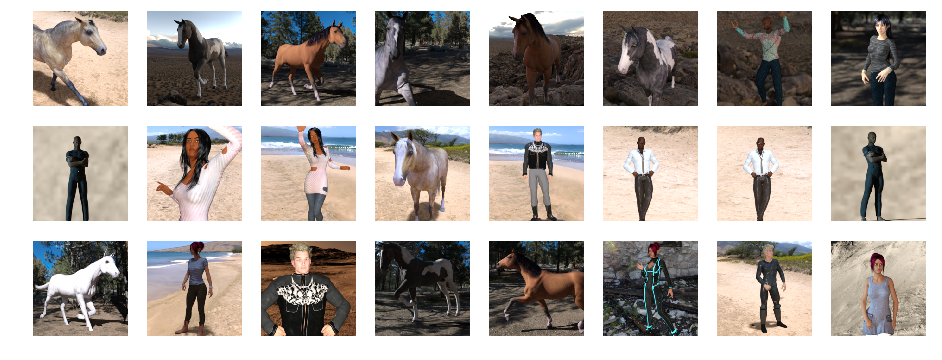

In [82]:
# Visualize training data
plt.figure(figsize=(16,6))
for i in range(24):
    fig = plt.subplot(3, 8, i+1)
    fig.set_axis_off()
    plt.imshow(X_train[i+1], cmap='gray')

In [83]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = tf.raw_ops.Sigmoid(x=Z).numpy()
    cache = A
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = tf.raw_ops.Relu(features=Z).numpy()
    
    cache = A
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = tf.raw_ops.ReluGrad(gradients=dA, features=Z).numpy()
    
    return dZ


def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    A = cache
    dZ = tf.raw_ops.SigmoidGrad(y=A, dy=dA).numpy()
    
    return dZ


def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [95]:
class Layer:
    """
    Interface for layers.
    """
    def __init__(self, input_shape: tuple, output_shape: tuple, trainable=True):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.trainable = trainable
        
    def forward(self, A_prev):
        pass
    
    def backward(self, dZ):
        pass
    
    def update_params(self, learning_rate):
        pass
    
    def __str__(self):
        return self.__class__.__name__ + " " + str(self.output_shape)
    
    
class Dense(Layer):
    def __init__(self, neurons: int, input_shape: tuple, activation: str):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        neurons (N) -- number of neurons
        input_shape -- (N_prev, m)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        """
        output_shape = (neurons, input_shape[1])
        super().__init__(input_shape, output_shape)
        self.neurons = neurons
        self.activation = activation
        self.initialize_params()
        
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (N, N_prev)
        self.b -- Biases, numpy array of shape (N, 1)
        '''
        self.W = np.random.randn(self.neurons, self.input_shape[0]) * 0.05
        self.b = np.zeros((self.neurons,1))
        
        
    def forward(self, A_prev):
        """
        Implement the forward propagation for the dense layer with activation function

        Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)

        Returns:
        A -- the output of the activation function, also called the post-activation value 
        
        Defintions:
        self.cache -- tuple of values (A_prev, activation_cache) stored for computing backward propagation efficiently

        """
        Z = np.dot(self.W, A_prev) + self.b
        if self.activation == "sigmoid":
            A, activation_cache = sigmoid(Z)

        elif self.activation == "relu":
            A, activation_cache = relu(Z)

        assert (A.shape == (self.W.shape[0], A_prev.shape[1]))
        self.cache = (A_prev, activation_cache)

        return A
    
    def backward(self, dA):
        """
        Implement the backward propagation for the dense layer with activation function

        Arguments:
        dA -- post-activation gradient for current layer l 
       
        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        
        Definitions:
        self.dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        self.db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, activation_cache = self.cache
        m = A_prev.shape[1]

        if self.activation == "relu":
            dZ = relu_backward(dA, activation_cache)
        elif self.activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
        self.dZ = dZ 
        self.dW = np.dot(dZ, A_prev.T)/m
        self.db = np.sum(dZ, axis=1, keepdims=True)/m
        dA_prev = np.dot(self.W.T, dZ)
        return dA_prev
    
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class Conv2D(Layer):
    def __init__(self, filters: int, filter_size: int, input_shape: tuple, padding="VALID", stride=1):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        filters (C) -- number of filters
        filter_size (f) -- size of filters
        input_shape -- (m, H, W, C)
        """
        output_shape = (input_shape[0], input_shape[1] - filter_size + 1, input_shape[2] - filter_size + 1, filters)
        super().__init__(input_shape, output_shape)
        self.filters = filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.initialize_params()
    
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (f, f, C_prev, n_C)
        self.b -- Biases, numpy array of shape (1, 1, 1, n_C)
        '''
        self.W = np.random.randn(self.filter_size, self.filter_size, self.input_shape[3], self.filters) * 0.05
        self.b = np.zeros((self.filters))
        

    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution function

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, H_prev, W_prev, C_prev)
        
        Returns:
        Z -- conv output
        """
        
        # Perform convolution
        Z = tf.raw_ops.Conv2D(input=A_prev, filter=self.W, strides=[self.stride]*4, padding=self.padding)
        # Add bias
        Z = tf.raw_ops.BiasAdd(value=Z, bias=self.b)
        
        # Save information in "cache" for the backprop
        self.cache = A_prev
        # Return the output
        return Z.numpy()
    
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution function
        
        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, H, W, C)
        
        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, H_prev, W_prev, C_prev)
                   
        Definitions:
        self.dW -- gradient of the cost with respect to the weights of the conv layer (W)
              numpy array of shape (f, f, C_prev, C)
        self.db -- gradient of the cost with respect to the biases of the conv layer (b)
              numpy array of shape (1, 1, 1, C)
        """

        # Retrieve information from "cache"
        A_prev = self.cache
        m = A_prev.shape[0]
        self.dZ = dZ
        self.A_prev = A_prev
        dA_prev = tf.raw_ops.Conv2DBackpropInput(input_sizes = A_prev.shape, filter = self.W, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.dW = tf.raw_ops.Conv2DBackpropFilter(input = A_prev, filter_sizes = self.W.shape, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()/m
        self.db = np.average(np.sum(dZ, axis=(1,2)), axis=0)
        return dA_prev
    
       
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db
        
class Maxpool(Layer):
    def __init__(self, input_shape, pool_size=2):
        self.ksize = [1, pool_size, pool_size, 1]
        self.strides = [1, pool_size, pool_size, 1]
        output_shape = (input_shape[0], input_shape[1]//pool_size, input_shape[2]//pool_size, input_shape[3])
        super().__init__(input_shape, output_shape, False)

        
    def forward(self, A_prev):
        Z = tf.raw_ops.MaxPool(input=A_prev, ksize=self.ksize, strides=self.strides, data_format='NHWC', padding="VALID").numpy()
        self.cache = (A_prev, Z)
        return Z
    
    def backward(self, dZ):
        A_prev, Z = self.cache
        dA_prev = tf.raw_ops.MaxPoolGrad(orig_input=A_prev, orig_output=Z, grad=dZ, ksize=self.ksize, strides=self.strides, padding="VALID", data_format='NHWC').numpy()
        return dA_prev

        
class ReLU(Layer):
    def __init__(self, input_shape):
        output_shape = input_shape
        super().__init__(input_shape, output_shape, False)

      
    def forward(self, Z):
        """
        Implement the RELU function.
        Arguments:
        Z -- Output of the linear layer, of any shape
        Returns:
        A -- Post-activation parameter, of the same shape as Z
        """

        A = tf.raw_ops.Relu(features=Z).numpy()
        self.cache = Z 
        return A

    def backward(self, dA):
        """
        Implement the backward propagation for a single RELU unit.
        Arguments:
        dA -- post-activation gradient, of any shape
        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        Z = self.cache
        dZ = tf.raw_ops.ReluGrad(gradients=dA, features=Z).numpy()

        return dZ
    

class Flatten(Layer):
    def __init__(self, input_shape):
        m, *shape = input_shape
        output_shape = (np.prod(shape), m)
        super().__init__(input_shape, output_shape, trainable=False)
        
    def forward(self, A_prev):
        m, *shape = A_prev.shape
        self.cache = A_prev.shape
        return A_prev.flatten().reshape(m,np.prod(shape)).T
    
    def backward(self, dZ):
        return dZ.T.reshape(self.cache)
    
        
class Model:
    def __init__(self, layers: list):
        self.layers = layers
        
    def fit(self, X, Y, epochs, learning_rate, batch_size, verbose): 
        # Initialize parameters
        history = list()
        m = Y.shape[1]
        chunks = np.linspace(0,m+1,m//batch_size+1).astype(int)
        for epoch in range(epochs):
            for i in range(len(chunks)-1):
                # FORWARD PROP
                Z = X[chunks[i]:chunks[i+1]]
                y = Y[:,chunks[i]:chunks[i+1]]
                for layer in self.layers:
                    Z = layer.forward(Z)

                # COST FUNCTION
                cost = compute_cost(Z, y)
                history.append(cost)
                if verbose == 1 and i == 0:
                    print("Cost epoch ", epoch, ": ", cost, sep="")

                # BACKWARD PROP
                dA = - (np.divide(y, Z) - np.divide(1 - y, 1 - Z)) # derivative of cost with respect to Z

                for layer in reversed(self.layers):
                    dA = layer.backward(dA)

                # UPDATE PARAMS
                for layer in self.layers:
                    layer.update_params(learning_rate)

        return history
    
    def predict(self, Z):
        for layer in self.layers:
            Z = layer.forward(Z)
        return Z
    
    def summary(self):
        print("-"*25)
        for layer in layers:
            print(layer)
            print("-"*25)
            
    def _cost(self, X, Y):
        Z = X
        for prop_layer in self.layers:
            Z = prop_layer.forward(Z)
        # COMPUTE COST
        return compute_cost(Z, Y)
    
    def gradcheck(self, X, Y, epsilon=1e-7, start=None, end=None):
        self.approx_grads = []
        self.true_grads = []
        for layer in self.layers[start:end]:
            if not layer.trainable:
                continue
            for i in range(layer.W.size):
                i = np.unravel_index(i, layer.W.shape)
                Wi = layer.W[i]
                layer.W[i] = Wi + epsilon
                J1 = self._cost(X, Y)
                layer.W[i] = Wi - epsilon
                J2 = self._cost(X, Y)
                layer.W[i] = Wi
                self.approx_grads.append((J1-J2)/(2*epsilon))
                
            for i in range(layer.b.size):
                i = np.unravel_index(i, layer.b.shape)
                bi = layer.b[i]
                layer.b[i] = bi + epsilon
                J1 = self._cost(X, Y)
                layer.b[i] = bi - epsilon
                J2 = self._cost(X, Y)
                layer.b[i] = bi
                self.approx_grads.append((J1-J2)/(2*epsilon))
        
        # FORWARD PROP
        Z = X
        for prop_layer in self.layers:
            Z = prop_layer.forward(Z)
        # BACKWARD PROP
        dA = - (np.divide(Y, Z) - np.divide(1 - Y, 1 - Z)) # derivative of cost with respect to AL

        for layer in reversed(self.layers):
            dA = layer.backward(dA)
        
        for layer in self.layers[start:end]:
            if not layer.trainable:
                continue
            self.true_grads = np.concatenate((self.true_grads, layer.dW.flatten(), layer.db.flatten()))
        self.approx_grads = np.array(self.approx_grads)
        self.true_grads = np.array(self.true_grads)
        return np.sqrt(np.sum(np.square(self.true_grads-self.approx_grads)))/(np.sqrt(np.sum(np.square(self.true_grads)))+np.sqrt(np.sum(np.square(self.approx_grads))))
    
        

In [108]:
initializer = "random_normal" # random_normal or glorot_uniform
keras_model = k.Sequential([ 
    k.layers.InputLayer(input_shape=(300,300,3)),
    k.layers.Conv2D(16,3, activation=None),
    k.layers.MaxPool2D(),
    k.layers.Conv2D(32,3, activation=None),
    k.layers.MaxPool2D(),
    k.layers.Conv2D(64,3, activation=None),
    k.layers.MaxPool2D(),
    k.layers.Conv2D(64,3, activation=None),
    k.layers.MaxPool2D(),
    k.layers.Conv2D(64,3, activation=None),
    k.layers.MaxPool2D(),
    k.layers.Flatten(),
    k.layers.Dense(512, activation="relu", kernel_initializer=initializer),
    k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)
])
keras_model.summary()

model_lr = 1e-2
model_epochs = 10

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 33, 33, 64)      

In [114]:
layers = []
for layer in keras_model.layers:
    layer_type = layer.name.split(sep="_")[0]
    input_shape = layer.input_shape
    if layer_type == "dense":
        neurons = layer.output_shape[1]
        activation = layer.activation.__name__
        layers.append(Dense(neurons, tuple(reversed(input_shape)), activation))
    elif layer_type == "flatten":
        layers.append(Flatten(input_shape))
    elif layer_type == "conv2d":
        filter_size = layer.kernel_size[0]
        filters = layer.output_shape[-1]
        layers.append(Conv2D(filters, filter_size, input_shape))
    elif layer_type == "max":
        layers.append(Maxpool(input_shape))

model = Model(layers)

In [119]:
# Select only m samples for fast training time during debugging
m = 320
X_train_norm = X_train[:m,...].reshape((m, 300, 300, 3)).astype(np.float64)/255
y_train_norm = y_train[:m].values.reshape(1,m).astype(float)
history = model.fit(X_train_norm, y_train_norm, epochs=model_epochs, learning_rate=model_lr, batch_size=32, verbose=1)

Cost epoch 0: 0.6607839587955733
Cost epoch 1: 0.6446405893335074
Cost epoch 2: 0.6256650442071019
Cost epoch 3: 0.6046236493860574
Cost epoch 4: 0.5805515883239248
Cost epoch 5: 0.5556649870235812
Cost epoch 6: 0.5308117228215837
Cost epoch 7: 0.5053801030257203
Cost epoch 8: 0.4825769847998331
Cost epoch 9: 0.4593377199882464


In [120]:
m = 256
X_test_norm = X_test[:m,...].reshape((m, 300, 300, 3)).astype(np.float64)/255
y_test_norm = y_test[:m].values.reshape(1,m).astype(float)
predictions = model.predict(X_test_norm)
print("Accuracy:", accuracy_score(y_test_norm.flatten(), predictions.flatten().round()))

Accuracy: 0.85546875


In [121]:
predictions

array([[0.45976821, 0.03860664, 0.31193251, 0.98646844, 0.9687463 ,
        0.32905867, 0.18591888, 0.8349157 , 0.09957845, 0.9787376 ,
        0.02150468, 0.83241704, 0.98315701, 0.04969479, 0.97620575,
        0.56706297, 0.12683797, 0.98457223, 0.3914871 , 0.96054917,
        0.26846782, 0.99559368, 0.02036916, 0.07616795, 0.05566152,
        0.92699669, 0.98989596, 0.77218662, 0.9947353 , 0.94776268,
        0.01593213, 0.98379048, 0.83671555, 0.97982678, 0.9884854 ,
        0.52413559, 0.20403157, 0.99151541, 0.64203377, 0.99179651,
        0.7564153 , 0.41132362, 0.95779634, 0.98620051, 0.99196368,
        0.37389677, 0.16525865, 0.96801904, 0.0925589 , 0.10259739,
        0.99150404, 0.98925495, 0.87368443, 0.98370133, 0.10055374,
        0.26503039, 0.28971423, 0.97429725, 0.96923259, 0.98025526,
        0.99594341, 0.94287578, 0.98011239, 0.99701313, 0.96122329,
        0.98824941, 0.33986744, 0.98842522, 0.0418281 , 0.2087303 ,
        0.77829761, 0.97368616, 0.97724666, 0.51